# Introduction

This is our project, which was developed as a semesterproject in the subject AI during our second semester of the softwaredevelopment bachelor. 
Our project contains an exploratory data analysis (EDA) over specific parts of the data, which helped us gain insight into the workings of the datasets. Furthermore the goal of the EDA was to uncover potential variables which could potentially alter the predictions we made based on the dataset. After the completion of the EDA, we used what we learned about the data to make predictions about the sales trends by using various predictions models such as SARIMAX.

So what are we trying to predict? The goal of the challenge is to predict sales data for a period of 28 days for Wallmart. This can be achieved since we've been given three different data sets, which describes the sales trends for the past 5 years. The data consists of 3049 individual products from the three different categories foods, household and hobbies. The products comes from 10 different stores across 3 different states. The data contains sales data for all these product for a period of 1942 days, which rougly adds up to 5 years.

Let's take a closer look at the datasets we've been handed;

* `sales_train.csv` This is our main training data. It contains columns over the days in the dataset and the amount of sales made of a given product for each specific day. This dataset also gives us other various information about each specific product such as `state_id`, `store_id`, `department_id`, `category_id` and `item_id`.
* `sell_prices.csv` Contains a list of the stores and item ID's together with the sales prices of the item as a weekly average.
* `calender.csv` This dataset contains a list of all the dates we're working with. This dataset also contains information about events such as the superbowl, christmas etc. which predictably alters the sales trend for certain periods. This helps us make better educated guesses as to why the data behaves as it does, and it also gives us information about predictable fluctuations in sales trends. The calendar dataset also gives us information about [SNAP](https://www.fns.usda.gov/snap/eligible-food-items) and SNAP days. This is relevant as days where the stamps are eligible for use in the stores, potentially can alter sales trends. This will be researched in greater length during the EDA. 



# Exploratory Data Analysis (EDA)

At the start of the project we conducted an exploratory data analysis. This was done first and foremost to learn as much as we could about the data as we didn't have that much prior knowledge about the datasets. The EDA also helps us uncover predicatble price fluctuations in the data. These can be caused by things such as varios events, foodstamps, seansons and more. As there was enormous amounts of data to examine and consider, we decided to limit our EDA to areas of the data we thought would give us the most value in terms of making accuracte predictions. The EDA is split up into th the following categories;

* Data structure
* Investgating sales fluctuations
* The effects of sales during Christmas
* Comparison of stores
* Comparison of categories and sub-categories
* Investigating SNAPs impact on total sales



In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics
import math


sampleSubmissionData = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
salesTrainValidationData = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sellPricesData = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
calendarData = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')

In [19]:
def getWeekdaysInRange(start, end, day):
    dates = []
    for i in range (start,end):
        if calendarData.loc[i].weekday == day:
            dates.append(calendarData.loc[i].date)
    return dates
def getEventDaysInRange(start, end):
    dates = []
    for i in range (start,end):
        if type(calendarData.loc[i].event_name_1) == str or type(calendarData.loc[i].event_name_2) == str:
            dates.append(calendarData.loc[i].date)
    return dates
def getSnapDaysInRange(start, end, state):
    dates = []
    for i in range (start,end):
        if (state == 'CA' and calendarData.loc[i].snap_CA or 
            state == 'TX' and calendarData.loc[i].snap_TX or 
            state == 'WI' and calendarData.loc[i].snap_WI):
            dates.append(calendarData.loc[i].date)
    return dates

## Data Structure

After the `.csv` files was loaded and the initial setup was completed we decided to investigate the contents of the files briefly by calling the `.head()` method on the files. We already had a faint idea what the files would contain, as we had looked at the [guildelines](https://mofc.unic.ac.cy/m5-competition/) outlying the scope and frame of the project. As previously mentioned we worked with three different data sets which are;

* `sales_train.csv`
* `sell_prices.csv`
* `calender.csv`


**Sales Train Data**

We explored the `sales_train.csv` file by calling the `.head()` method. We found that the dataframe contains a list of all the products available in the stores. We also found that the dataframe has columns describing which category it belongs to, which store it's from in which state and how many of each given product was sold each day during the 5 year period.

In [ ]:
salesTrainValidationData.head()

**Sell Prices Data**

We also explored the `sales_train.csv` file by calling the `.head()` method. This reveals that this dataframe also contains information about each product. The `wm_year_wk` column tells us which week we're looking at for a given product and `sell_price` tells us the averae sales price for the product in question week by week. In otherwords this file describes the average sell price for each product for each week of the 5 year period, where the other table listed how many of each product was sold each day. 

In [ ]:
sellPricesData.head()

**Calendar Data**

Lastly we also explored the `calender.csv` file by calling the .head() method. This revelas a dataframe with several interesting columns. The dataframe has the same `wm_yr_wk` column as the `sales_price.csv` file which again shows us which week each specific day belongs to. The dataframe also gives us information about events through the `event_name_1` and `event_type_1`. There are also columns called `event_name2` and `event_type2`, which we learned was only there because you cannot have lists in a dataframe. This ultimately means that the only reason theres duplicate event name and type columns is incase there are multiple events during the same day. Lastly, the dataframe also gives us information about which days are and aren't SNAP days through the `snap_CA`,`snap_TX` and `snap_WI` columns. SNAP days are days in which customers eligible for the [SNAP](https://www.fns.usda.gov/snap/eligible-food-items) program are eligible to spend the stamps in a given store.

In [ ]:
calendarData.head()

> # Initial EDA

The first thing we did was to find out exactly how many stores we were working with. We already knew the answer from studying the guidelines, but we mostly wanted to test the data.

In [ ]:
storeCount = salesTrainValidationData.groupby('state_id')['store_id'].nunique().reset_index()
storeCount.columns = ['State', '# of Stores']
storeCount

*We found*
* There are 10 stores across 3 states

To learn more about the data we decided it would be relevant to look at the total volume of sales from all stores in all states over the entire period. We were hoping that this would uncover any obvious points of interest in the data. We constructed the following graph to visually represent the total sales over the 5 year period.

In [ ]:
totalSalesPerDay = salesTrainValidationData.copy().loc[:,"d_1":"d_1913"].sum().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1:1913].loc[:,'date'].values)
totalSalesPerDay = totalSalesPerDay.set_index(pd.to_datetime(dates))
totalSalesPerDay.plot(title="Total sales per day", figsize=(30,8), legend=None)
plt.style.use('bmh')
plt.xlabel('')
plt.ylabel('Sales')
plt.show()

***We found***
* Theres an overall upwards trend
* Seasonal trends (sales go slightly down in the later months of each year)
* All shops have have a day at the end of the year where they sell 0 items
* Constant fluctuations throughout indicating days with low sales followed by days with high sales

> # Investigating sale fluctuations

Next we wanted to further explore why the previous graph was so fluctuating so much. We suspected that these rapid fluctuations was due to weekends and events. Therefore we decided to develop the following graph to see if weekends and events really was the cause of the constant spiking. We felt that since the fluctuations were so constant, that a snapshot of 6 months of the data would be easier to work with while investigtaing the sales fluctuations. This pattern of only looking a 6 months at a time will repeat from here on out. Looking at too big a dataset doesnt make sense and it makes the data easier to handle. Looking at a graph that describes a 5 years period is too big and umanageable, which makes it hard to get any usefull visual representation from them.

In [ ]:
sales6Months = salesTrainValidationData.copy().loc[:,"d_1733":"d_1913"].sum().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
sales6Months = sales6Months.set_index(pd.to_datetime(dates))

sales1Year = salesTrainValidationData.copy().loc[:,"d_1548":"d_1913"].sum().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1548:1913].loc[:,'date'].values)
sales1Year = sales1Year.set_index(pd.to_datetime(dates))

f,ax = plt.subplots(3,1,figsize=(24,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(sales6Months, zorder=2)
ax[0].set_title('Total sales per day for the last 6 months with weekends')
ax[0].set_ylabel('Sales')

for date in getWeekdaysInRange(1733, 1913, 'Friday'):
    ax[0].axvline(pd.Timestamp(date), color='#d5dee0', zorder=1, linewidth=8)
    
for date in getWeekdaysInRange(1733, 1913, 'Saturday'):
    ax[0].axvline(pd.Timestamp(date), color='#d5dee0', zorder=1, linewidth=8)
    
for date in getWeekdaysInRange(1733, 1913, 'Sunday'):
    ax[0].axvline(pd.Timestamp(date), color='#d5dee0', zorder=1, linewidth=8)

ax[1].plot(sales1Year, zorder=2)
ax[1].set_title('Total sales per day for the last year with events')
ax[1].set_ylabel('Sales')

for date in getEventDaysInRange(1548, 1913):
    ax[1].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=8)

ax[2].plot(sales1Year, zorder=2)
ax[2].set_title('Total sales per day for the last year with weekends and events')
ax[2].set_ylabel('Sales')

for date in getWeekdaysInRange(1548, 1913, 'Friday'):
    ax[2].axvline(pd.Timestamp(date), color='#d5dee0', zorder=1, linewidth=8)
    
for date in getWeekdaysInRange(1548, 1913, 'Saturday'):
    ax[2].axvline(pd.Timestamp(date), color='#d5dee0', zorder=1, linewidth=8)
    
for date in getWeekdaysInRange(1548, 1913, 'Sunday'):
    ax[2].axvline(pd.Timestamp(date), color='#d5dee0', zorder=1, linewidth=8)

for date in getEventDaysInRange(1548, 1913):
    ax[2].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=8)

plt.show()

***We found***
* Weekends have a significant effect on sales
* Sales rises quickly from friday and starts to fall down on monday, while still having significant higher sales compared to regular weekdays
* Most events do not seem to have a significant impact on sales
* Few events seem to increase sales, but is inconclusive
* The events are often located during weekend spikes, which makes it hard to tell if the event had a big impact
* One or two events have a negative impact on sales

This graph concludes our initial EDA in which we learned a great deal about data. The information we obtained from here was valuable later on. 

> # The effects of sales during christmas

We noticed that in all of our previous graphs, that sometime in december the total sales would consistently drop to 0. We suspected that these drops was caused by the store being closed during the holidays and therefore we developed the following graph. Since it's only one day it won't have the greatest impact on our predictions, and should most likely not be accounted for in the data set since its a clear outlier. 

In [ ]:
totalSalesPerDayFirstWinter = salesTrainValidationData.copy().loc[:,"d_1768":"d_1798"].sum().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1768:1798].loc[:,'date'].values)
totalSalesPerDayFirstWinter = totalSalesPerDayFirstWinter.set_index(pd.to_datetime(dates))

totalSalesPerDaySecondWinter = salesTrainValidationData.copy().loc[:,"d_1403":"d_1433"].sum().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1403:1433].loc[:,'date'].values)
totalSalesPerDaySecondWinter = totalSalesPerDaySecondWinter.set_index(pd.to_datetime(dates))

f,ax = plt.subplots(2,1,figsize=(20,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(totalSalesPerDayFirstWinter)
ax[0].set_title('Winter sales 2015')
ax[0].axvline(pd.Timestamp("2015-12-25"), color='#cfb4b4', zorder=1, linewidth=3)

ax[1].plot(totalSalesPerDaySecondWinter)
ax[1].set_title('Winter sales 2014')
ax[1].axvline(pd.Timestamp("2014-12-25"), color='#cfb4b4', zorder=1, linewidth=3)

plt.show()

***We found***
* All wallmart stores have 0 sales christmas day, most likely because they are closed

> # Comparison of stores

We wanted to explore if the different states were equal in terms of sales or if some states were outperforming others. In addition to this, we also just wanted to see if there was something interested to learn from developing and studying this graph. Inorder to have a manageable dataset we selected the most recent 6 months of the data to study.

In [ ]:
totalSalesPerDayPast6Months = salesTrainValidationData.copy().groupby('state_id').sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
totalSalesPerDayPast6Months = totalSalesPerDayPast6Months.set_index(pd.to_datetime(dates))

totalSalesPerDayPast6Months.plot(title="Total sales by states", figsize=(30,8))
plt.style.use('bmh')
plt.show()

***We found***
* States are fairly average, taking into account that CA has 4 stores instead of 3

After our initial investigation into sales for each state, we wanted more information about each area. Therefore we developed the following graph in which we obtained more information about the invidivual stores in the states. For these graphs, we also used the data for the last 6 months.

In [ ]:
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)

totalSalesPerDayPast6MonthsCA = salesTrainValidationData.copy().groupby('store_id').sum().loc["CA_1":"CA_4", "d_1733":"d_1913"].transpose()
totalSalesPerDayPast6MonthsCA = totalSalesPerDayPast6MonthsCA.set_index(pd.to_datetime(dates))
totalSalesPerDayPast6MonthsCA.transpose()

totalSalesPerDayPast6MonthsTX = salesTrainValidationData.copy().groupby('store_id').sum().loc["TX_1":"TX_3", "d_1733":"d_1913"].transpose()
totalSalesPerDayPast6MonthsTX = totalSalesPerDayPast6MonthsTX.set_index(pd.to_datetime(dates))
totalSalesPerDayPast6MonthsTX.transpose()

totalSalesPerDayPast6MonthsWI = salesTrainValidationData.copy().groupby('store_id').sum().loc["WI_1":"WI_3", "d_1733":"d_1913"].transpose()
totalSalesPerDayPast6MonthsWI = totalSalesPerDayPast6MonthsWI.set_index(pd.to_datetime(dates))
totalSalesPerDayPast6MonthsWI.transpose()

f,ax = plt.subplots(3,1,figsize=(20,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(totalSalesPerDayPast6MonthsCA)
ax[0].set_title('Sales by store in CA')
ax[0].legend(('CA_1', 'CA_2', 'CA_3', 'CA_4'), loc='upper left')

ax[1].plot(totalSalesPerDayPast6MonthsTX)
ax[1].set_title('Sales by store in TX')
ax[1].legend(('TX_1', 'TX_2', 'TX_3'), loc='upper left')

ax[2].plot(totalSalesPerDayPast6MonthsWI)
ax[2].set_title('Sales by store in WI')
ax[2].legend(('WI_1', 'WI_2', 'WI_3'), loc='upper left')
plt.show()

***We found***
* CA_3 is outpeforming the other stores in CA by a considerable amount, while CA_4 is underperforming
* TX and WI stores are all performing at about the same amount
* The differences in stores performing could be caused by outside forces such as nearby population and location

> # Comparison of categories

Next we wanted to investigate the categories from the dataset. We did this in hopes that it would have some clues we could use during our prediction. First we made a graph which shows the total distribution of sales over all categories from all states/stores.

In [ ]:
totalSalesPerDayPast6Months = salesTrainValidationData.copy().groupby('cat_id').sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
totalSalesPerDayPast6Months = totalSalesPerDayPast6Months.set_index(pd.to_datetime(dates))

totalSalesPerDayPast6Months.plot(title="Total sales by categories across all stores", figsize=(30,8))
plt.style.use('bmh')
plt.show()

***We found***
* Foods are by far the topselling category
* Hobbies are selling the least, slightly behind household

Afterwards we wanted to further investigate if there was a descrepancy between sales in the various categories in different states. However based on the previous graph we were fully expecting foods to be ahead followed by household and hobby categories.

In [ ]:
totalSalesPerDayPast6Months = salesTrainValidationData.copy().groupby(by=['state_id','cat_id'], axis=0).sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
totalSalesPerDayPast6Months = totalSalesPerDayPast6Months.set_index(pd.to_datetime(dates))

f,ax = plt.subplots(3,1,figsize=(20,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(totalSalesPerDayPast6Months['CA'])
ax[0].set_title('Sales by category in CA')
ax[0].legend(('FOODS', 'HOBBIES', 'HOUSEHOLD'), loc='upper left')

ax[1].plot(totalSalesPerDayPast6Months['TX'])
ax[1].set_title('Sales by category in TX')
ax[1].legend(('FOODS', 'HOBBIES', 'HOUSEHOLD'), loc='upper left')

ax[2].plot(totalSalesPerDayPast6Months['WI'])
ax[2].set_title('Sales by category in WI')
ax[2].legend(('FOODS', 'HOBBIES', 'HOUSEHOLD'), loc='upper left')
plt.show()

***We found***
* All states seem to be following the pattern of food being the topselling category, followed by hobbies and household

Then we decided that it would be interesting to see if there was anything to learn from exploring the various categories subcategories which we did in the following graph.

In [ ]:
totalSalesPerDayPast6Months = salesTrainValidationData.copy().groupby('dept_id').sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
totalSalesPerDayPast6Months = totalSalesPerDayPast6Months.set_index(pd.to_datetime(dates))

totalSalesPerDayPast6Months.plot(title="Total sales by subcategories across all stores", figsize=(30,8))
plt.style.use('bmh')
plt.legend(loc='upper left')
plt.show()

***We found***
* Of subcategories, FOODS_3 is the most popular by far, and could be what is causing the food category to outpeform hobbies and household by such a big margin

Afterwards we again checked if there was any noticeable discrepancy between subcategories between the different states from the data.

In [ ]:
caSales = salesTrainValidationData.copy().loc[salesTrainValidationData['store_id'].isin(['CA_1', 'CA_2', 'CA_3', 'CA_4'])]
caSales = caSales.groupby('dept_id').sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
caSales = caSales.set_index(pd.to_datetime(dates))

txSales = salesTrainValidationData.copy().loc[salesTrainValidationData['store_id'].isin(['TX_1', 'TX_2', 'TX_3'])]
txSales = txSales.groupby('dept_id').sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
txSales = txSales.set_index(pd.to_datetime(dates))

wiSales = salesTrainValidationData.copy().loc[salesTrainValidationData['store_id'].isin(['WI_1', 'WI_2', 'WI_3'])]
wiSales = wiSales.groupby('dept_id').sum().loc[:,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
wiSales = wiSales.set_index(pd.to_datetime(dates))

f,ax = plt.subplots(3,1,figsize=(24,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(caSales)
ax[0].set_title('Total sales of subcategories for CA')
ax[0].legend(('FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2'), loc='upper left')
ax[0].set_ylabel('Sales')

ax[1].plot(txSales)
ax[1].set_title('Total sales of subcategories for TX')
ax[1].legend(('FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2'), loc='upper left')
ax[1].set_ylabel('Sales')

ax[2].plot(wiSales)
ax[2].set_title('Total sales of subcategories for WI')
ax[2].legend(('FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2'), loc='upper left')
ax[2].set_ylabel('Sales')

plt.show()

***We found***
* The pattern from before remains true across all states

> # Investigating SNAPs impact on total sales

To end our EDA, we wanted to investigate if SNAP and SNAP days has a noticeable effect on sales. If they do, we wanted to know how much they impacted sales and how we could use this information in our predictions. To investigate this we developed the following graphs.

In [ ]:
foods = salesTrainValidationData.copy().loc[salesTrainValidationData['store_id'].isin(['CA_1', 'CA_2', 'CA_3', 'CA_4'])]
foods = foods.groupby('dept_id').sum().loc["FOODS_1":"FOODS_3":,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
foods = foods.set_index(pd.to_datetime(dates))

hobbies = salesTrainValidationData.copy().loc[salesTrainValidationData['store_id'].isin(['CA_1', 'CA_2', 'CA_3', 'CA_4'])]
hobbies = hobbies.groupby('dept_id').sum().loc["HOBBIES_1":"HOBBIES_2":,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
hobbies = hobbies.set_index(pd.to_datetime(dates))

household = salesTrainValidationData.copy().loc[salesTrainValidationData['store_id'].isin(['CA_1', 'CA_2', 'CA_3', 'CA_4'])]
household = household.groupby('dept_id').sum().loc["HOUSEHOLD_1":"HOUSEHOLD_2":,"d_1733":"d_1913"].transpose()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
household = household.set_index(pd.to_datetime(dates))

f,ax = plt.subplots(3,1,figsize=(24,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(foods)
ax[0].set_title('Overall sales for food subcategories in CA with snap days')
ax[0].legend(('FOODS_1', 'FOODS_2', 'FOODS_3'), loc='upper left')

for date in getSnapDaysInRange(1733, 1913, 'CA'):
    ax[0].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=3)

ax[1].plot(hobbies)
ax[1].set_title('Overall sales for hobby subcategories in CA with snap days')
ax[1].legend(('HOBBIES_1', 'HOBBIES_2'), loc='upper left')

for date in getSnapDaysInRange(1733, 1913, 'CA'):
    ax[1].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=3)

ax[2].plot(household)
ax[2].set_title('Overall sales for household subcategories in CA with snap days')
ax[2].legend(('HOUSEHOLD_1', 'HOUSEHOLD_2'), loc='upper left')

for date in getSnapDaysInRange(1733, 1913, 'CA'):
    ax[2].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=3)

plt.show()

***We found***
* SNAP days does not seem to a major impact on sales
* It could seem that the regular weekdays are slightly higher than usual when there's SNAP days

Lastly we wanted to see if the individual states were doing SNAP differently and how this would affect the data. 

In [ ]:
caSales = salesTrainValidationData.copy().groupby('store_id').sum().loc['CA_1':'CA_4',"d_1733":"d_1913"].sum().transpose().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
caSales = caSales.set_index(pd.to_datetime(dates))

txSales = salesTrainValidationData.copy().groupby('store_id').sum().loc['TX_1':'TX_3',"d_1733":"d_1913"].sum().transpose().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
txSales = txSales.set_index(pd.to_datetime(dates))

wiSales = salesTrainValidationData.copy().groupby('store_id').sum().loc['WI_1':'WI_3',"d_1733":"d_1913"].sum().transpose().to_frame()
dates = pd.to_datetime(calendarData.copy().loc[1733:1913].loc[:,'date'].values)
wiSales = wiSales.set_index(pd.to_datetime(dates))

f,ax = plt.subplots(3,1,figsize=(24,8))
f.tight_layout(pad=3.0)
plt.style.use('bmh')

ax[0].plot(caSales, zorder=2)
ax[0].set_title('Total sales for CA with snap days')

for date in getSnapDaysInRange(1733, 1913, 'CA'):
    ax[0].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=3)

ax[1].plot(txSales, zorder=2)
ax[1].set_title('Total sales for TX with snap days')

for date in getSnapDaysInRange(1733, 1913, 'TX'):
    ax[1].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=3)

ax[2].plot(wiSales, zorder=2)
ax[2].set_title('Total sales for WI with snap days')

for date in getSnapDaysInRange(1733, 1913, 'WI'):
    ax[2].axvline(pd.Timestamp(date), color='#cfb4b4', zorder=1, linewidth=3)

plt.show()

***We found***
* It remains hard to tell if SNAP has a major impact on sales
* The pattern of when SNAP days appear can seem to have an impact on the weekend fluctuations, leading to a more stable pattern when the SNAP days are spread out

# Models

For the models, we decided to do it on a total sales per day basis, instead of the competitions format of predicting on each item. This was done to reduce the complexity of the models since we mostly wanted to see how the different models holds up against each other.

> # Baseline


In [23]:
def calculateSlope(series, n, sumX):
    def a():
        a = 0
        for i in range (0, n):
            a += (i + 1) * series.iloc[i]
        return a * n
    def b():
        sumY = 0
        for i in range (0, n):
            sumY += i + 1
        return series.sum() * sumY
    def c():
        c = 0
        for i in range (0, n):
            c += (i + 1)**2
        return c * n
    def d():
        return sumX**2
    return (a() - b()) / (c() - d())

def calculateYIntercept(series, n, m, sumX):
    def e():
        return series.sum()
    def f():
        return m * sumX
    return (e() - f()) / n

def calculateTrend(series, count):
    n = len(series.index)

    sumX = 0
    for i in range (0, n):
        sumX += i + 1

    m = calculateSlope(series, n, sumX)
    yi = calculateYIntercept(series, n, m, sumX)

    trend = []
    for i in range(n + 1, n + 1 + count):
        trend.append(m * i + yi)

    return pd.Series(trend)

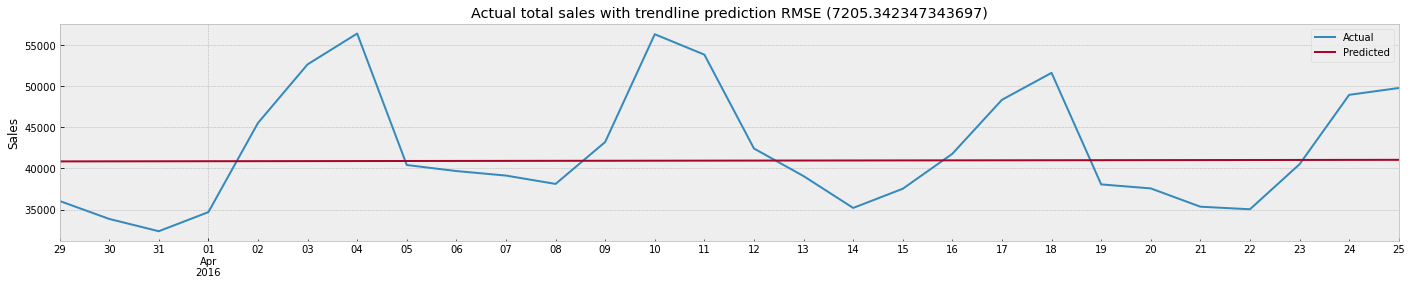

In [25]:
train = salesTrainValidationData.copy().loc[:,'d_1':'d_1885'].sum()
validation = salesTrainValidationData.copy().loc[:,'d_1886':'d_1913'].sum()
trend = calculateTrend(train, 28)
predicted = trend.to_frame().set_index(validation.index.values).transpose().iloc[0]
rmse = math.sqrt(metrics.mean_squared_error(validation, predicted))

compare = pd.DataFrame({
    'Actual': validation,
    'Predicted': predicted
})

dates = pd.to_datetime(calendarData.copy().loc[1886:1913].loc[:,'date'].values)
compare = compare.set_index(pd.to_datetime(dates))
compare
compare.plot(title='Actual total sales with trendline prediction RMSE (' + str(rmse) + ')', figsize=(24,4))
plt.style.use('bmh')
plt.xlabel('')
plt.ylabel('Sales')
plt.show()


A baseline is a simple prediction that can be used to evaluate whether or not the predictions from a more advanced model is good. For a baseline we have calculated the trend of total sales for the whole period except for the last 28 days, which will be used to score the prediction. When compared with the actual values for the last 28 days, the baseline got a RMSE score of 7205.

> # SARIMAX

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


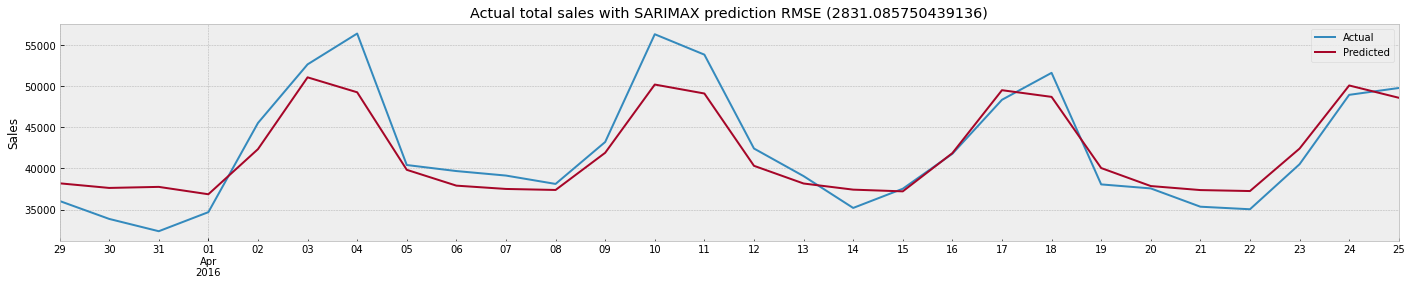

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

validation = salesTrainValidationData.copy().loc[:,'d_1886':'d_1913'].sum()
endog = salesTrainValidationData.copy().loc[:,'d_1':'d_1885'].sum().reset_index().drop(columns=['index'])
model = SARIMAX(endog, order=(4, 1, 1), seasonal_order=(4, 1, 1, 7))
fit = model.fit()
yhat = fit.forecast(28)
rmse = math.sqrt(metrics.mean_squared_error(validation, yhat.values))

compare = pd.DataFrame({
    'Actual': validation,
    'Predicted': yhat.values
})

dates = pd.to_datetime(calendarData.copy().loc[1886:1913].loc[:,'date'].values)
compare = compare.set_index(pd.to_datetime(dates))
compare.plot(title='Actual total sales with SARIMAX prediction RMSE (' + str(rmse) + ')', figsize=(24,4))
plt.style.use('bmh')
plt.xlabel('')
plt.ylabel('Sales')
plt.show()

SARIMA is an extension of ARIMA that includes seasonality, which could be a good fit for the total sales data, due to the weekly fluctuations. As with the baseline the total sales for the whole period except for the last 28 days were used as training data, and the last 28 days to validate the fit of the model. An important parameter in our case is the m parameter which describes the number of time steps for a single seasonal period. This parameter was set to 7 to match the weekly fluctuations. The model got a score of around 2792 which is much better than the baseline.

> # Random Forest

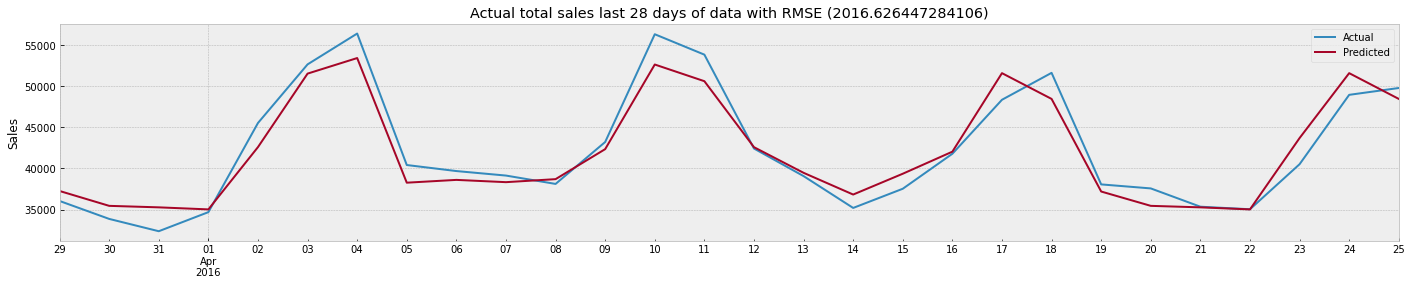

In [20]:
salesTrain = salesTrainValidationData.copy().loc[:,"d_1":"d_1885"].sum().to_frame()
salesValidation = salesTrainValidationData.copy().loc[:,"d_1886":"d_1913"].sum().to_frame()
salesTrain.columns = ['dailySales']
salesValidation.columns = ['dailySales']
datesTrain = calendarData[0:1885].copy()
datesValidation = calendarData[1885:1913].copy()
datesTrain = datesTrain[['weekday','month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
datesValidation = datesValidation[['weekday','month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
datesTrain['dailySales'] = salesTrain['dailySales'].values
datesValidation['dailySales'] = salesValidation['dailySales'].values
featuresTrain = pd.get_dummies(datesTrain)
featuresValidation = pd.get_dummies(datesValidation)

for c in featuresTrain.columns:
    if c not in featuresValidation.columns:
        featuresValidation[c] = c
        featuresValidation[c] = 0

labelsTrain = np.array(featuresTrain['dailySales'])
featuresTrain = featuresTrain.drop('dailySales', axis=1)
labelsValidation = np.array(featuresValidation['dailySales'])
featuresValidation = featuresValidation.drop('dailySales', axis=1)
featuresTrain = np.array(featuresTrain)
featuresValidation = np.array(featuresValidation)

rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(featuresTrain, labelsTrain)
predictions = rf.predict(featuresValidation)
rmse = math.sqrt(metrics.mean_squared_error(labelsValidation, predictions))

compare = pd.DataFrame({
    'Actual': labelsValidation,
    'Predicted': predictions
})

dates = pd.to_datetime(calendarData.copy().loc[1886:1913].loc[:,'date'].values)
compare = compare.set_index(pd.to_datetime(dates))
compare
compare.plot(title='Actual total sales last 28 days of data with RMSE (' + str(rmse) + ')', figsize=(24,4))
plt.style.use('bmh')
plt.xlabel('')
plt.ylabel('Sales')
plt.show()

For features, we selected:
* `weekday, month, year, snap_CA, snap_TX, snap_WI, wm_yr_wk and events` from `calendar.csv` which tells what day of the year the sales are reffering to, which states had snap on the specific day aswell as any potential events.
* `d_1, d_2, d_3 ... d_1913` from `sales_train_validation.csv` which we join with the date information.

We then trained the model on all the available days except the last 28, which we used for validation, seeing as the competition will be based on how well the predictions are for the future 28 days.

As seen on the picture above, comparing the model to the actual sales, the random forest model shows clear use of the weekly swings in sales, and we can conclude its impacted by the SNAP and event days since each weekend is predicted to be different, which is a clear signature that the other variables had an effect.

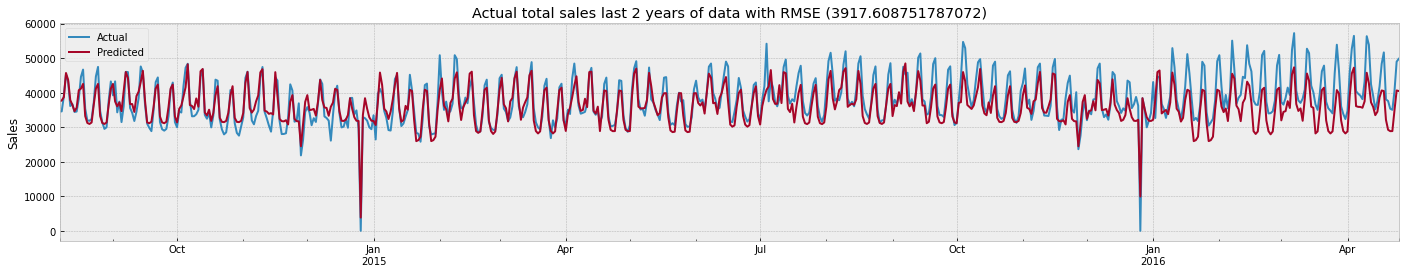

In [21]:
salesTrain = salesTrainValidationData.copy().loc[:,"d_1":"d_1285"].sum().to_frame()
salesValidation = salesTrainValidationData.copy().loc[:,"d_1286":"d_1913"].sum().to_frame()
salesTrain.columns = ['dailySales']
salesValidation.columns = ['dailySales']
datesTrain = calendarData[0:1285].copy()
datesValidation = calendarData[1285:1913].copy()
datesTrain = datesTrain[['weekday','month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
datesValidation = datesValidation[['weekday','month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
datesTrain['dailySales'] = salesTrain['dailySales'].values
datesValidation['dailySales'] = salesValidation['dailySales'].values
featuresTrain = pd.get_dummies(datesTrain)
featuresValidation = pd.get_dummies(datesValidation)

for c in featuresTrain.columns:
    if c not in featuresValidation.columns:
        featuresValidation[c] = c
        featuresValidation[c] = 0

labelsTrain = np.array(featuresTrain['dailySales'])
featuresTrain = featuresTrain.drop('dailySales', axis=1)
labelsValidation = np.array(featuresValidation['dailySales'])
featuresValidation = featuresValidation.drop('dailySales', axis=1)
featuresTrain = np.array(featuresTrain)
featuresValidation = np.array(featuresValidation)

rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(featuresTrain, labelsTrain)
predictions = rf.predict(featuresValidation)
rmse = math.sqrt(metrics.mean_squared_error(labelsValidation, predictions))

compare = pd.DataFrame({
    'Actual': labelsValidation,
    'Predicted': predictions
})

dates = pd.to_datetime(calendarData.copy().loc[1286:1913].loc[:,'date'].values)
compare = compare.set_index(pd.to_datetime(dates))
compare
compare.plot(title='Actual total sales last 2 years of data with RMSE (' + str(rmse) + ')', figsize=(24,4))
plt.style.use('bmh')
plt.xlabel('')
plt.ylabel('Sales')
plt.show()

This random forest is using the same type of data as the one with a 28-day prediction. After having made the first one, we wanted to see how well we could predict sales over a longer period, this being 2 years, to see how well it would hold up.

As can be seen on the graph, the predictions gets worse the further ahead we are predicting, which is an indicator that the random forest model is not taking the overall upwards trend of wallmart sales into account.

Besides this, we feel it holds up quite well for the first year or so of predicting, seeing as the training data is substantially smaller in this model since the prediction part of the data split is bigger.